### Chain Using LangGraph
In this section we will see how we can build a simple chain using Langgraph that uses 4 important concepts

- How to use chat messages as our graph state
- How to use chat models in graph nodes
- How to bind tools to our LLM in chat models
- How to execute the tools call in our graph nodes 

In [21]:
import os
from dotenv import load_dotenv
load_dotenv()

True

#### How to use chat messages as our graph state
##### Messages

We can use messages which can be used to capture different roles within a conversation.
LangChain has various message types including HumanMessage, AIMessage, SystemMessage and ToolMessage.
These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Every message have these important components.

- content - content of the message
- name - Specify the name of author
- response_metadata - optionally, a dict of metadata (e.g., often populated by model provider for AIMessages)

In [22]:
from langchain_core.messages import AIMessage,HumanMessage
from pprint import pprint

# example of using messages with manual appending of messages
messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
messages.append(HumanMessage(content=f"I want to learn coding",name="Ravi"))
messages.append(AIMessage(content=f"Which programming language you want to learn",name="LLMModel"))
messages.append(HumanMessage(content=f"I want to learn python programming language",name="Ravi"))

for message in messages:
    message.pretty_print()


================================== Ai Message ==================================
Name: LLMModel

Please tell me how can I help
================================ Human Message =================================
Name: Ravi

I want to learn coding
================================== Ai Message ==================================
Name: LLMModel

Which programming language you want to learn
================================ Human Message =================================
Name: Ravi

I want to learn python programming language


In [23]:
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv
load_dotenv()

llm = ChatGroq(api_key=os.getenv('GROQ_API_KEY'), model="qwen-qwq-32b")
response = llm(messages)
print("Response from LLM:")
pprint(response)

Response from LLM:
AIMessage(content='\n<think>\nOkay, the user wants to learn Python. Let me start by breaking down the best steps for a beginner. First, they\'ll need to install Python. I should mention the official website and maybe recommend using Python 3.11 or the latest stable version. Then, an IDE or text editor is important. PyCharm, VS Code, and Jupyter Notebook are popular choices. I should list those with some brief descriptions.\n\nNext, learning the basics is crucial. They\'ll need to understand syntax, data types, control structures, functions, and OOP. Maybe suggest some key topics to focus on. Then, practical projects are essential for applying knowledge. Simple projects like a calculator or to-do list can help. I should give a few examples.\n\nResources are the next step. Free resources like Codecademy, freeCodeCamp, and official documentation are good. Books like "Python Crash Course" are also recommended. Online courses from Coursera or Udemy could be mentioned too.

### Tools in Agentic AI
Tools can be integrated with the LLM models to interact with external systems. External systems can be API's, third party tools or LLMs.

Whenever a query is asked the model can choose to call the tool and this query is based on the 
natural language input and this will return an output that matches the tool's schema

In [24]:
def add(a:int,b:int)->int:
    """
    This function adds two numbers
    Args:
        a (int): first number
        b (int): second number
    Returns:
        int: sum of a and b
    """
    return a+b

#### Binding tool with LLM

In [25]:
# example of using messages with tool calling, binding the tool to the LLM
llm_with_tool = llm.bind_tools([add])

# invoke the LLM with a tool call, this will call the tool with the input
tool_call = llm_with_tool.invoke([HumanMessage(content="What is 10 plus 2?", name="Ravi")])

In [26]:
# here we can see the tool call in the response, this mentions the tool name and the arguments
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 10, 'b': 2},
  'id': 'call_y7zx',
  'type': 'tool_call'}]

### Using Messages as State with Reducers

In [27]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class State(TypedDict):
    message:list[AnyMessage]

#### So, why use reducers with above?
#### Reducers
Now, we have a minor problem!

As we discussed, each node will return a new value for our state key messages.

But, this new value will override the prior messages value.

As our graph runs, we want to append messages to our messages state key.

We can use reducer functions to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.

But, to append messages, we can use the pre-built add_messages reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our messages key with the add_messages reducer function as metadata.

In [28]:
from langgraph.graph.message import add_messages
from typing import Annotated

class State(TypedDict):
    # This is a state object that contains a list of messages, with the reducer function ie add_messages
    # this will append the messages to the state
    messages: Annotated[list[AnyMessage], add_messages]

#### Now below is the example how inital_messages and ai message gets appended to the state using Reducer function add_messages

In [29]:
initial_messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
initial_messages.append(HumanMessage(content=f"I want to learn coding",name="Ravi"))
initial_messages

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Ravi')]

In [30]:
ai_message=AIMessage(content=f"Which programming language you want to learn",name="LLMModel")
ai_message

AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel')

In [31]:
result_messages = add_messages(initial_messages,ai_message)
# now you can see the messages are appended to the state using reducer function
for message in result_messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: LLMModel

Please tell me how can I help
================================ Human Message =================================
Name: Ravi

I want to learn coding
================================== Ai Message ==================================
Name: LLMModel

Which programming language you want to learn


### Now lets Create the Chatbot node functionality

In [32]:
from langgraph.graph.message import add_messages
from typing import Annotated

class State(TypedDict):
    # This is a state object that contains a list of messages, with the reducer function ie add_messages
    # this will append the messages to the state
    messages: Annotated[list[AnyMessage], add_messages]

In [33]:
def llm_tool(state:State):
    return {'messages':[llm_with_tool.invoke(state['messages'])]}

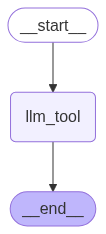

In [34]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)

builder.add_node("llm_tool", llm_tool)

builder.add_edge(START, 'llm_tool')
builder.add_edge("llm_tool", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))
# now here you can see that from Start the edge goes to the llm_tool, 
# but it should go to the llm_tool node when it has to perform addition

In [35]:
## invocation

messages=graph.invoke({"messages":"What is 2 plus 2"})

for message in messages["messages"]:
    message.pretty_print()

# you can see the llm tool node is still has not been invoked 

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (call_arz7)
 Call ID: call_arz7
  Args:
    a: 2
    b: 2


### Now lets perform the tool cal with conditional edge 

In [36]:
# create tools 
tools = [add]

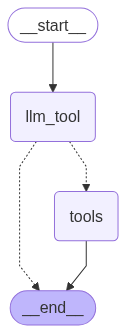

In [37]:
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(State)

# Add nodes
builder.add_node("llm_tool", llm_tool)
builder.add_node("tools", ToolNode(tools))

# Add edge
builder.add_edge(START, "llm_tool")

# If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
# If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
builder.add_conditional_edges("llm_tool", tools_condition)
builder.add_edge("tools", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [41]:
# Invocation

messages = graph.invoke({"messages":"What is 2 plus 2"})
messages
# you can see the the llm_tool node performs tool cal based on the message

{'messages': [HumanMessage(content='What is 2 plus 2', additional_kwargs={}, response_metadata={}, id='2c4f9956-195c-4296-a8ee-19395441cecb'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sks8', 'function': {'arguments': '{"a": 2, "b": 2}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 156, 'prompt_tokens': 196, 'total_tokens': 352, 'completion_time': 0.389934992, 'prompt_time': 0.035706482, 'queue_time': 0.418473207, 'total_time': 0.425641474}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_1e88ca32eb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-19821318-83fd-4190-94f6-3f5669c71a17-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 2}, 'id': 'call_sks8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 196, 'output_tokens': 156, 'total_tokens': 352}),
  ToolMessage(content='4', name='add', id='f983c82c-c157-4fac-9649-7bcae0028bb6', tool_call_id='call_sks8')]}

In [42]:
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (call_sks8)
 Call ID: call_sks8
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4


In [40]:
messages=graph.invoke({"messages":"What is Machine Learning"})
messages

# for message in messages["messages"]:
#     message.pretty_print()

{'messages': [HumanMessage(content='What is Machine Learning', additional_kwargs={}, response_metadata={}, id='080daab7-9070-4aa2-9a1e-16760e8944d5'),
  AIMessage(content='Machine Learning is a subset of artificial intelligence (AI) that focuses on developing algorithms and statistical models enabling computers to perform tasks without explicit instructions. Instead, these systems learn patterns from data to make decisions or predictions. For example, email spam filters or recommendation systems on platforms like Netflix use Machine Learning to improve their performance over time based on user behavior and input data.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 297, 'prompt_tokens': 193, 'total_tokens': 490, 'completion_time': 0.741417533, 'prompt_time': 0.033891228, 'queue_time': 7.571820138, 'total_time': 0.775308761}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_512a3da6bb', 'finish_reason': 'stop', 'logprobs': None}, id='run-136f5f3c-a